# Surveys Module Assignment

## Setup and Data Loading

For this assignment, you need to download data manually from ICPSR:
- [American National Election Studies (ANES) 2020 Time Series Study](https://www.icpsr.umich.edu/web/ICPSR/studies/38034)

You should use either the Stata file or the Delimited file.

In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


# Example Code

The next few Python cells provide examples of common tasks like renaming variables, recoding variables, and specifying the structure of the survey. Some of this code you can reuse directly, and some you will need to modify to work with the variables and values you are using.

## Loading and Recoding Data

First we load in data from the 2020 ANES Times Series study. Then we give the variables we're going to use friendlier names and recode them from numbers to meaningful answers.

We're going to ignore warnings we get about variable types and save that issue for another day. The warning means that the `pd.read_csv` function found variables that have values that are not all the same type (e.g., strings) and so wasn't sure what type to make them. We can use `pd.read_stata` instead.

In [24]:
# Load the 2020 ANES Time Series data
# df = pd.read_csv("/Users/libbyh/Documents/git/si313_instructors/answer_keys/data/38034-0001-Data.tsv", sep='\t')
df = pd.read_stata("/Users/libbyh/Documents/git/si313_instructors/answer_keys/data/38034-0001-Data.dta", convert_categoricals=False)

# Rename variables with friendly names
df = df.rename(columns={
    "V202072":  "voted_raw",        # 1=yes, 2=no
    "V202073":  "pres_vote_raw",    # who they voted for
    "V200010B": "wt_full_post",     # full-sample post-election weight
    "V201600":  "sex",              # 1=male, 2=female
    "V201507X": "age",              # numeric age
    "V201231X": "party_id7",        # 7-point party ID, 1=Strong Democrat, 7=Strong Republican 
    "V201157": "ft_trump"           # Trump feelings thermometer
})

# Recode presidential vote (V202073) into voted_for and a 0/1 turnout indicator
vote_map = {
    1: "Biden",
    2: "Trump",
    3: "Jorgensen",
    4: "Hawkins",
    5: "Other"
}

df["voted_for"] = df["pres_vote_raw"].map(vote_map)

# Voted: from voted_raw (1=Yes, 2=No)
voted_map = {
    "1. Yes, voted for President": 1,
    "2. No, didn't vote for President": 0
}

df["voted"] = df["voted_raw"].map(voted_map)

# Female: from sex (1=male, 2=female)
df["female"] = (
    df["sex"]
      .replace({1: 0, 2: 1})
      .where(df["sex"].isin([1, 2]))
      .astype("Int64")  # pandas' nullable integer type
)

# age is already numeric, just make sure it's Int64
df["age"] = pd.to_numeric(df["age"], errors="coerce")

# Party ID: Keep only 1–7, set everything else to NaN
df["party_id7"] = df["party_id7"].where(df["party_id7"].between(1, 7))

Create a minimal dataframe. This step is optional, but it helps to have something small in case we run into errors and have to fix them.

In [25]:
model_df = df[["ft_trump", "party_id7", "age", "wt_full_post"]].dropna()

## Weighted Analysis

Remember that the ANES is weighted to estimated the real population from its sample. We need to use weights when running statistical tests or estimating the full population.

Plotting is a good first step. It doesn't make sense to run statistics if the data is all over the place.

First, I make a dataframe that summarizes the feeling thermometer values by `party_id_7`. In this dataframe, each row is a `party_id_7` value, and the `mean_ft` is a weighted average of the Trump feeling thermometer question for that party identity.

In [26]:
grouped = (
    model_df
      .assign(weighted_ft=model_df["ft_trump"] * model_df["wt_full_post"])
      .groupby("party_id7", as_index=False)
      .agg(
          weighted_ft_sum=("weighted_ft", "sum"),
          wt_sum=("wt_full_post", "sum"),
          n=("ft_trump", "size")
      )
)

grouped["mean_ft"] = grouped["weighted_ft_sum"] / grouped["wt_sum"]
grouped = grouped[["party_id7", "mean_ft", "n"]]

grouped.head(7)

,party_id7,mean_ft,n
0,1.0,14.910705,1796
1,2.0,26.507391,789
2,3.0,25.307557,881
3,4.0,38.573596,876
4,5.0,59.279013,782
5,6.0,63.112353,759
6,7.0,81.739003,1545


Now let's plot the same data. Sometimes it's easier to see patterns visually than in the numbers.

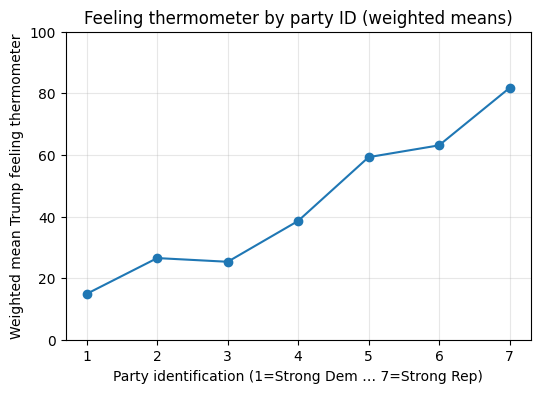

In [27]:
plt.figure(figsize=(6, 4))
plt.plot(grouped["party_id7"], grouped["mean_ft"], marker="o")
plt.xlabel("Party identification (1=Strong Dem … 7=Strong Rep)")
plt.ylabel("Weighted mean Trump feeling thermometer")
plt.title("Feeling thermometer by party ID (weighted means)")
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.show()

Then I calculate a linear regression to estimate the Trump feeling thermometer with 2 predictors: party id and age. I remember to add the weights with the `weights` argument for `sm.WLS`.

In [30]:
# using statsmodels.api
y = model_df["ft_trump"]
X = sm.add_constant(model_df[["party_id7", "age"]])

model_tft = sm.WLS(y, X, weights=model_df["wt_full_post"]).fit(cov_type='HC0')
print(model_tft.summary())


                            WLS Regression Results                            
Dep. Variable:               ft_trump   R-squared:                       0.445
Model:                            WLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     2876.
Date:                Wed, 25 Feb 2026   Prob (F-statistic):               0.00
Time:                        13:49:56   Log-Likelihood:                -36502.
No. Observations:                7428   AIC:                         7.301e+04
Df Residuals:                    7425   BIC:                         7.303e+04
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3499      1.408     -0.249      0.8

`statsmodels` accepts other syntax for calculating that model (see [more info in the docs](https://www.statsmodels.org/stable/api.html)). Here's another way to do it, and you can see the results are the same.

In [31]:
# using statsmodels.formula.api
model_tft_alt = smf.wls(
    formula="ft_trump ~ party_id7 + age",
    data=model_df,
    weights=model_df["wt_full_post"],
).fit(cov_type='HC0')

print(model_tft_alt.summary())

                            WLS Regression Results                            
Dep. Variable:               ft_trump   R-squared:                       0.445
Model:                            WLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     2876.
Date:                Wed, 25 Feb 2026   Prob (F-statistic):               0.00
Time:                        13:50:12   Log-Likelihood:                -36502.
No. Observations:                7428   AIC:                         7.301e+04
Df Residuals:                    7425   BIC:                         7.303e+04
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3499      1.408     -0.249      0.8

## Interpreting Results

### Party ID
Holding age constant, moving one step more Republican on the 7‑point party ID scale is associated, on average, with about an 11‑point increase in the feeling thermometer.

Example: If someone moves from 2 (“Not-very strong Democrat”) to 3 (“Independent‑Democrat”), the model predicts their feeling score on the Trump thermometer goes up by about 11 points.

Statistical meaning: The z‑statistic is 75.3 and p < 0.001, so this relationship is very precisely estimated and statistically strong. The 95% CI (10.7, 11.3) says the true effect per step is almost certainly around 11 points, not something small.

This is the kind of “partisan sorting / affective polarization” effect we’d expect on a Trump thermometer.

### Age

Holding party ID constant, an additional one year of age is associated with about a 0.03‑point increase in the Trump thermometer score. Over 10 years, that’s about 0.3 points; over 40 years, less than 1 point. So the age effect is tiny.

Statistical meaning: The z‑statistic is 1.42, p = 0.155, and the 95% CI (‑0.011, 0.069) includes 0. That means we cannot reject the null of no age effect; statistically, this is consistent with age having no linear association when we control for party ID.

### Summary

Partisanship matters a lot (about 11 points per step) when we're predicting how someone feels about Trump; age barely matters and is not statistically significant when we account for partisanship.


## AI Appendix (if applicable)

If you used AI during this assignnment, explain
1. what part of the work it was used for; 
2. what AI tools you used; 
3. the prompts you used; 
4. how you analyzed the AI work for accuracy; and, 
5. steps you took to rework and revise your final documents so that they were both factually accurate and reflected your own voice and style.

I used ChatGPT in Dia to figure out how to keep only the meaningful values for party id. Here's the prompt I used:
```
    how do i keep only 1-7?
    V201231X: PRE: SUMMARY: Party ID
    Value Label Unweighted
    Frequency
    %
    -9 -9. Refused 31 0.4 %
    -8 -8. Don't know 4 0.0 %
    1 1. Strong Democrat 1961 23.7 %
    2 2. Not very strong Democrat 899 10.9 %
    3 3. Independent-Democrat 975 11.8 %
    4 4. Independent 968 11.7 %
    5 5. Independent-Republican 879 10.6 %
    6 6. Not very strong Republican 833 10.1 %
    7 7. Strong Republican 1730 20.9 %
    Total 8,280 100%
```
It returned
```
    # Keep only 1–7, set everything else to NaN
    df["party_id7"] = df["V201231X"].where(df["V201231X"].between(1, 7))
```
I had already renamed my variables, so I changed "V201231X" to "party_id7" to match my "voice".

The plot I drew between party ID and Trump thermometer shows only 1-7 values for `party_id7`, so I think this worked.